# TF isoform data


## TODO

- check valid clones only in all data
- get sequence information
- remove partners that didn't test positive with any isoform
- remove single isoforms
    - but need to add first to paralogs
- Look into effect of number of PPIs per TF
- combine categories to get paralog data

In [1]:
from itertools import combinations

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_seq_comparison_data,
                          load_ref_vs_alt_isoforms_table,
                          load_tf_families,
                          )

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
y1h = load_y1h_pdi_data()
# m1h = load_m1h_activation_data()
isoforms = load_valid_isoform_clones()
idents = load_seq_comparison_data()

#tfs = tfs.drop(columns=['tpm_stdev'])
#tfs = tfs.set_index(['gene', 'isoacc', 'tiss'])
#tfs = tfs.unstack(level='tiss')
#tfs.columns = tfs.columns.get_level_values(1)

#tfs.to_csv('tf_isoform_tissue_tpms.tsv', sep='\t')

In [3]:
y2h.head()

,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_name,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result,seq_confirmation_3AT,seq_confirmation_LW,ad_clone_acc
0,TFfnlr07_001_002_003_004_005_006,5,A01,ATF2,ATF2-1,101414,ATF2,54731,tf_isoform_ppis,2,4,0,4,True,True,True,ATF2|1/6|12H04
1,TFfnlr07_001_002_003_004_005_006,5,A02,ATF2,ATF2-1,101414,COL8A1,3053,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|1/6|12H04
2,TFfnlr07_001_002_003_004_005_006,5,A03,ATF2,ATF2-1,101414,EFEMP2,2906,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|1/6|12H04
3,TFfnlr07_001_002_003_004_005_006,5,A04,ATF2,ATF2-1,101414,FOSL2,12504,tf_isoform_ppis,2,4,0,4,NaN,False,True,ATF2|1/6|12H04
4,TFfnlr07_001_002_003_004_005_006,5,A05,ATF2,ATF2-1,101414,JDP2,13624,tf_isoform_ppis,2,4,0,4,True,True,True,ATF2|1/6|12H04


In [4]:
print('Numbers for the isoform experiment (not paralogs or controls):')
print(y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
        'ad_clone_acc'].nunique(),
      'isoforms attempted to test for PPIs')
print(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        (y2h['Y2H_result'].notnull()),
        'ad_clone_acc'].nunique(),
        'isoforms successfully tested for at least one PPI')
print(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
              (y2h['Y2H_result'] == True),
        'ad_clone_acc'].nunique(),
        'isoforms with at least one positive PPI')
print(((y2h['category'] == 'tf_isoform_ppis') &
        (y2h['Y2H_result'] == True)).sum(),
        'positive PPIs, involving',
        y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                (y2h['Y2H_result'] == True), 'db_gene_symbol'].nunique(),
        'protein partners')

Numbers for the isoform experiment (not paralogs or controls):
308 isoforms attempted to test for PPIs
287 isoforms successfully tested for at least one PPI
200 isoforms with at least one positive PPI
2259 positive PPIs, involving 574 protein partners


In [5]:
yang = pd.read_excel('../data/external/Yang_et_al_Cell_2014_Table_S2.xlsx',
                     sheet_name='2B-Isoform PPIs')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
# isoforms with >= 2 tested and at least one positive PPI
# count pairwise combinations and genes
yang['2_or_more_iso_per_gene'] = yang['Gene_Symbol'].map((yang.groupby('Gene_Symbol')['Isoform_ID'].nunique() > 1))

In [7]:
yang['2_or_more_partners_per_iso'] = yang['Isoform_ID'].map(yang['Isoform_ID'].value_counts() >= 2)

In [8]:
yang['2_or_more_iso_with_2_or_more_partners_per_gene'] = yang['Gene_Symbol'].map(yang.loc[yang    ['2_or_more_partners_per_iso'], 
         :].groupby('Gene_Symbol')['Isoform_ID'].nunique() >= 2).fillna(False)

In [9]:
yang.loc[yang['2_or_more_iso_with_2_or_more_partners_per_gene'], 'Gene_Symbol'].nunique()

87

In [10]:
import itertools

def count_pairs_per_gene(df):
    pairs_count = 0
    for iso_a, iso_b in itertools.combinations(df['Isoform_ID'].unique(), 2):
        if (((df['Isoform_ID'] == iso_a) & (df['Interaction_Found'] == 'positive')).any()
            and ((df['Isoform_ID'] == iso_b) & (df['Interaction_Found'] == 'positive')).any()
            and len(set(df.loc[df['Isoform_ID'] == iso_a, 'Interactor_ID']).intersection(set(df.loc[df['Isoform_ID'] == iso_b, 'Interactor_ID']))) >= 2):
            pairs_count += 1
    return pairs_count

iso_pairs_per_gene = yang.groupby('Gene_Symbol').apply(count_pairs_per_gene)
print(iso_pairs_per_gene.sum(), (iso_pairs_per_gene >= 1).sum())

100 65


In [11]:
yang.loc[yang['2_or_more_iso_with_2_or_more_partners_per_gene'], :]

,Entrez_Gene_ID,Gene_Symbol,Isoform_ID,Category,Interactor_Entrez_Gene_ID,Interactor_Symbol,Interactor_ID,Interaction_Found,2_or_more_iso_per_gene,2_or_more_partners_per_iso,2_or_more_iso_with_2_or_more_partners_per_gene
0,81,ACTN4,ACTN4_1,reference,373,TRIM23,TRIM23,negative,True,True,True
1,81,ACTN4,ACTN4_1,reference,51778,MYOZ2,MYOZ2,positive,True,True,True
2,81,ACTN4,ACTN4_4,alternative,373,TRIM23,TRIM23,positive,True,True,True
3,81,ACTN4,ACTN4_4,alternative,51778,MYOZ2,MYOZ2,negative,True,True,True
4,207,AKT1,AKT1_1,reference,8115,TCL1A,TCL1A,positive,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
2021,387032,ZKSCAN4,ZKSCAN4_3,alternative,84547,PGBD1,PGBD1,NaN,True,True,True
2022,387032,ZKSCAN4,ZKSCAN4_3,alternative,84838,ZNF496,ZNF496,positive,True,True,True
2023,387032,ZKSCAN4,ZKSCAN4_3,alternative,158399,ZNF483,ZNF483,positive,True,True,True
2024,387032,ZKSCAN4,ZKSCAN4_3,alternative,342945,ZSCAN22,ZSCAN22,positive,True,True,True


In [12]:
isoforms['gene'].nunique()

310

In [13]:
isoforms.shape

(758, 7)

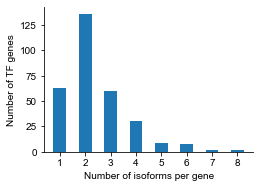

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.5, 2.5)
isoforms['gene'].value_counts().plot.hist(ax=ax, range=(0.75, 8.25), bins=15)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of isoforms per gene')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(1, 9))
plt.savefig('../figures/isoform_clones_per_tf_gene.pdf',
            bbox_inches='tight')

In [15]:
all_tfs = load_tf_families()
all_tfs.shape[0]

1639

In [16]:
iso_y1h_pos = set(y1h.loc[y1h[y1h.columns[2:]].any(axis=1), 'unique_acc'].values)

In [17]:
iso_gte_1_pos_ppi_iso_data_only = set(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['Y2H_result'] == True), 'ad_clone_acc'].unique()) 
iso_gte_1_pos_ppi_all_data = set(y2h.loc[(y2h['Y2H_result'] == True), 'ad_clone_acc'].unique())
pos_in_only_non_isoform_ppi_data = iso_gte_1_pos_ppi_all_data.difference(iso_gte_1_pos_ppi_iso_data_only)
print(len(pos_in_only_non_isoform_ppi_data),
      'isoforms that are Y2H positive in a dataset outside the isoform')
print(pos_in_only_non_isoform_ppi_data)
y2h.loc[(y2h['ad_clone_acc'].isin(pos_in_only_non_isoform_ppi_data)) & (y2h['Y2H_result'] == True), :]

4 isoforms that are Y2H positive in a dataset outside the isoform
{'NFAT5|1/2|02F01', 'PKNOX1|4/4|06G03', 'PKNOX1|3/4|06H03', 'ELF2|2/4|04E01'}


,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_name,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result,seq_confirmation_3AT,seq_confirmation_LW,ad_clone_acc
1085,TFfnlr07_025_026_027_028_029_030,30,B01,ELF2,ELF2-2,100179,BANP,6534,non_paralog_control,2,4,0,4,True,True,True,ELF2|2/4|04E01
3115,TFfnlr07_067_068_069_070_071_072,67,C05,PKNOX1,PKNOX1-3,100276,CCDC196,14908,tf_paralog_ppis,2,4,0,4,True,True,True,PKNOX1|3/4|06H03
3127,TFfnlr07_067_068_069_070_071_072,67,D05,PKNOX1,PKNOX1-4,100240,CCDC196,14908,tf_paralog_ppis,2,4,0,4,True,True,True,PKNOX1|4/4|06G03
4797,TFfnlr07_097_098_099_xxx_xxx_xxx,98,E10,NFAT5,NFAT5-1,101044,ING3,14384,rrs_isoforms,2,4,0,4,True,True,True,NFAT5|1/2|02F01


In [18]:
y2h = load_isoform_and_paralog_y2h_data()
# restict to TF isoform data (i.e. not paralogs etc.)
ppi = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['category',
               'ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'Y2H_result']].copy()
# at least one positive per PPI partner
ppi = ppi.loc[ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['Y2H_result']
                 .transform(lambda row: (row == True).any()),
              :]
# at least one successfully tested PPI per isoform
ppi = ppi.loc[ppi.groupby('ad_clone_acc')
                  ['Y2H_result']
                  .transform(lambda x: (x.notnull().any())),
              :]
# at least two partners per isoform
ppi = ppi.loc[ppi.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
isoforms = load_valid_isoform_clones()
iso_pairs = load_ref_vs_alt_isoforms_table()
iso_pairs['both_iso_y2h_pos'] = (iso_pairs['clone_acc_ref'].isin(iso_gte_1_pos_ppi_iso_data_only) &
                                 iso_pairs['clone_acc_alt'].isin(iso_gte_1_pos_ppi_iso_data_only))
iso_pairs['both_iso_y2h_pos_all_data'] = (iso_pairs['clone_acc_ref'].isin(iso_gte_1_pos_ppi_all_data) &
                                          iso_pairs['clone_acc_alt'].isin(iso_gte_1_pos_ppi_all_data))

In [19]:
iso_pairs['both_iso_y2h_or_y1h_pos'] = (iso_pairs['clone_acc_ref'].isin(iso_gte_1_pos_ppi_all_data.union(iso_y1h_pos)) &
                                        iso_pairs['clone_acc_alt'].isin(iso_gte_1_pos_ppi_all_data.union(iso_y1h_pos)))

In [20]:
iso_pairs['isoform_a'] = iso_pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
iso_pairs['isoform_b'] = iso_pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [21]:
iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2)
               & iso_pairs['both_iso_y2h_pos_all_data'], :].shape

(87, 57)

In [22]:
genes_nonzero_pair = set(iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2)
               & iso_pairs['both_iso_y2h_pos_all_data'] , 'gene_symbol'].unique())
len(genes_nonzero_pair)

53

In [23]:
iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2) &
              iso_pairs['both_iso_y2h_or_y1h_pos'], :].shape

(96, 57)

In [24]:
# Y1H rescue
genes_y1h_rescue = set(iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2) &
                     iso_pairs['both_iso_y2h_or_y1h_pos'],
                     'gene_symbol'].unique())
print(len(genes_y1h_rescue))
print(genes_y1h_rescue.difference(genes_nonzero_pair))

57
{'FOXJ2', 'MEIS1', 'PRRX1', 'RARG'}


In [25]:
rescue_pairs = iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2) &
              (iso_pairs['both_iso_y2h_or_y1h_pos'] ^
               iso_pairs['both_iso_y2h_pos_all_data']), :]
rescue_iso = set(rescue_pairs[['clone_acc_ref', 'clone_acc_alt']].values.flatten()).difference(iso_gte_1_pos_ppi_all_data)
print(len(rescue_iso))
print(rescue_iso)
rescue_pairs

9
{'NFIX|4/4|08D05', 'PPARG|4/4|10H03', 'PRRX1|2/3|09F06', 'MEIS1|2/2|09G04', 'GRHL3|6/7|08G10', 'HNF4A|4/6|10A10', 'RARG|1/2|08F10', 'GRHL3|2/7|08A10', 'FOXJ2|2/2|06B11'}


,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.0,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,13.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,False,False,True,PRRX1-2,PRRX1-1
6,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,True,602,607,16,16,True,False,False,False,False,False,False,False,0.0,0.0,False,98.4,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,False,0.436213,0.248480,-0.187733,False,False,True,GRHL3-3,GRHL3-2
8,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|6/7|08G10,ENST00000361548,NaN,False,True,True,602,523,16,16,True,False,False,True,True,False,False,False,0.0,0.0,False,84.5,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,False,0.436213,0.155513,-0.280700,False,False,True,GRHL3-3,GRHL3-6
38,MEIS1,ENSG00000143995,Homeodomain,False,MEIS1|1/2|09A04,MEIS1|2/2|09G04,ENST00000398506,ENST00000488550,False,False,False,463,378,11,11,True,True,False,True,True,False,False,False,NaN,NaN,False,78.3,6.0,0.0,6.0,6.0,0.0,0.0,6.0,-6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,True,-0.954097,-1.243943,-0.289846,False,False,True,MEIS1-1,MEIS1-2
70,PPARG,ENSG00000132170,Nuclear receptor,True,PPARG|1/4|10G02,PPARG|4/4|10H03,ENST00000287820,ENST00000650840,False,False,False,505,250,7,5,True,True,True,True,True,True,False,False,0.0,0.0,False,48.5,6.0,0.0,6.0,6.0,0.0,0.0,6.0,-6.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,1.0,1.0,0.500000,True,2.423347,0.801302,-1.622045,False,False,True,PPARG-1,PPARG-4
240,FOXJ2,ENSG00000065970,Forkhead,False,FOXJ2|1/2|06F10,FOXJ2|2/2|06B11,ENST00000162391,ENST00000428177,False,False,True,574,526,10,8,False,True,False,True,False,False,False,False,0.0,0.0,False,89.7,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,True,6.550576,1.167440,-5.383136,False,False,True,FOXJ2-1,FOXJ2-2
253,RARG,ENSG00000172819,Nuclear receptor,True,RARG|1/2|08F10,RARG|2/2|08C10,ENST00000425354,ENST00000338561,False,False,True,454,443,8,8,True,False,False,False,False,False,False,False,0.0,0.0,False,88.7,0.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,3.0,2.0,3.0,2.0,0.666667,True,2.410078,2.846196,0.436118,False,False,True,RARG-1,RARG-2
394,NFIX,ENSG00000008441,SMAD,True,NFIX|1/4|08H03,NFIX|4/4|08D05,ENST00000397661,NaN,False,True,False,441,353,9,8,False,True,True,True,False,True,False,False,0.0,0.0,False,75.3,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,3.0,1.000000,True,1.314330,2.371762,1.057432,False,False,True,NFIX-1,NFIX-4
428,HNF4A,ENSG00000101076,Nuclear receptor,True,HNF4A|1/6|10D

In [26]:
iso_pairs['n_min_PPI'] = iso_pairs[['n_positive_PPI_ref_filtered', 'n_positive_PPI_alt_filtered']].min(axis=1)
iso_pairs['n_min_PDI'] = iso_pairs[['n_positive_PDI_ref_filtered', 'n_positive_PDI_alt_filtered']].min(axis=1)

In [27]:
(iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2)
               & iso_pairs['both_iso_y2h_pos_all_data'] , 
               ['gene_symbol', 'isoform_a', 'isoform_b', 'n_PPI_successfully_tested_in_ref_and_alt',
       'n_shared_PPI', 'n_min_PPI', 'PPI_jaccard']]
               .to_csv('../output/non_zero_isoform_pairs.tsv',
               index=False,
               sep='\t'))

In [28]:
iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2)
               & ~iso_pairs['both_iso_y2h_pos']
               & iso_pairs['both_iso_y2h_pos_all_data'], :]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,n_min_PPI,n_min_PDI
97,ELF2,ENSG00000109381,Ets,False,ELF2|2/4|04E01,ELF2|1/4|03A11,ENST00000358635,NaN,False,True,NaN,533,552,7,7,True,False,True,False,True,True,False,False,0.0,0.0,False,79.8,0.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.745244,6.025830,3.280586,False,True,True,ELF2-2,ELF2-1,0.0,NaN
432,PKNOX1,ENSG00000160199,Homeodomain,False,PKNOX1|1/4|11H11,PKNOX1|3/4|06H03,ENST00000291547,ENST00000432907,False,False,True,436,319,10,7,True,False,False,False,False,False,False,False,NaN,NaN,False,73.2,4.0,0.0,4.0,4.0,0.0,0.0,4.0,-4.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,9.0,9.0,2.0,9.0,2.0,0.222222,True,NaN,1.482472,NaN,False,True,True,PKNOX1-1,PKNOX1-3,0.0,2.0
433,PKNOX1,ENSG00000160199,Homeodomain,False,PKNOX1|1/4|11H11,PKNOX1|4/4|06G03,ENST00000291547,NaN,False,True,True,436,318,10,7,True,False,False,False,True,False,False,False,NaN,NaN,False,72.9,4.0,0.0,3.0,3.0,0.0,0.0,3.0,-3.0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,8.0,9.0,2.0,8.0,1.0,0.111111,True,NaN,1.414036,NaN,False,True,True,PKNOX1-1,PKNOX1-4,0.0,2.0


In [29]:
iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2)
               & iso_pairs['both_iso_y2h_pos'] &
    (iso_pairs['both_iso_y2h_pos_all_data'] ^ iso_pairs['both_iso_y2h_pos']), :]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,n_min_PPI,n_min_PDI


In [30]:
iso_pairs['pdi_n_max'] = iso_pairs['n_PDI_successfully_tested_in_ref_and_alt'] - (iso_pairs['n_min_PDI'] - iso_pairs['n_shared_PDI'])

In [31]:
iso_pairs.loc[iso_pairs['PDI_jaccard'].notnull(),
              ['gene_symbol',
               'clone_acc_ref',
               'clone_acc_alt',
               'PDI_jaccard',
               'n_min_PDI',
               'pdi_n_max']].to_csv('../output/PDI_isoform_pairs.tsv', sep='\t', index=False)

In [32]:
iso_pairs.shape

(447, 60)

In [33]:
(isoforms.groupby('gene').size() >= 2).sum()

247

In [34]:
iso_pairs.notnull().sum()

gene_symbol                                              447
Ensembl_gene_ID                                          447
family                                                   447
is_dimerizing_TF_family                                  447
clone_acc_ref                                            447
clone_acc_alt                                            447
Ensembl_transcript_IDs_ref                               433
Ensembl_transcript_IDs_alt                               273
is_ref_novel_isoform                                     447
is_alt_novel_isoform                                     447
is_MANE_select_isoform_cloned                            414
n_aa_ref                                                 447
n_aa_alt                                                 447
n_exons_ref                                              447
n_exons_alt                                              447
is_alternative_N_terminal                                447
is_alternative_C_termina

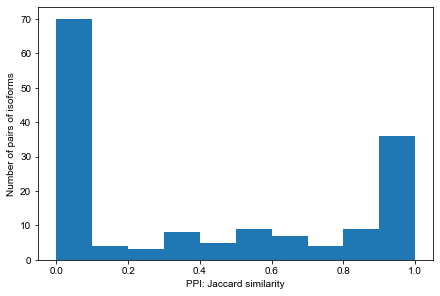

In [35]:
fig, ax = plt.subplots(1, 1)
ax.hist(iso_pairs['PPI_jaccard'], range=(0, 1), bins=10)
ax.set_ylabel('Number of pairs of isoforms')
ax.set_xlabel('PPI: Jaccard similarity')
plt.savefig('../figures/PPI_jaccard_dist.pdf')

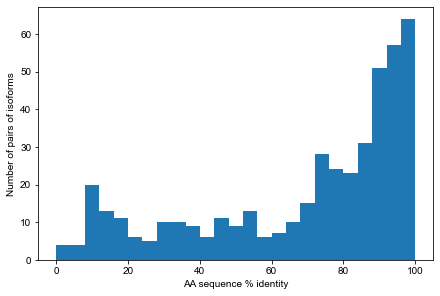

In [36]:
fig, ax = plt.subplots(1, 1)
ax.hist(iso_pairs['aa_seq_pct_id'], range=(0, 100), bins=25)
ax.set_ylabel('Number of pairs of isoforms')
ax.set_xlabel('AA sequence % identity')
plt.savefig('../figures/aa_seq_pct_id_hist.pdf')

In [37]:
#for col in iso_pairs.columns[4:]:
#    plt.hist(iso_pairs[col], bins=30)
#    plt.xlabel(col)
#    plt.ylabel('count')
#    plt.show()

In [38]:
iso_pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,n_min_PPI,n_min_PDI,pdi_n_max
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,1.0,-1.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,True,True,True,ZBTB18-1,ZBTB18-2,3.0,0.0,1.0
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,13.0,13.0,0.00,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,False,False,True,PRRX1-2,PRRX1-1,0.0,NaN,NaN
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,9.0,11.0,11.0,9.0,9.0,0.818182,True,1.552087,0.773129,-0.778958,False,False,True,PRRX1-2,PRRX1-3,NaN,9.0,11.0
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN,False,False,False,POU2F1-2,POU2F1-1,NaN,NaN,NaN
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389,False,False,False,ATF3-1,ATF3-2,NaN,NaN,NaN


### Explore PDI/PPI profile differences and sequence similarity

Look into:
- PPI and PDI Jaccard distribution
  - Faceted by degree
- PPI versus PDI Jaccard/Simpson
  - Faceted by number of interactors
- PPI/PDI Jaccard versus sequence similarity

TODO
- Compare randomly selected isoforms from different genes (from paralog data)

In [43]:
iso_pairs['PPI_simpson'] = iso_pairs['n_shared_PPI'] / iso_pairs['n_min_PPI']
iso_pairs['PDI_simpson'] = iso_pairs['n_shared_PDI'] / iso_pairs['n_min_PDI']

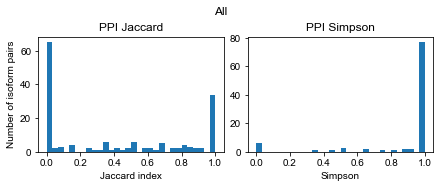

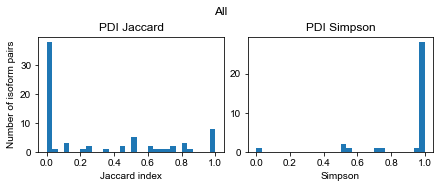

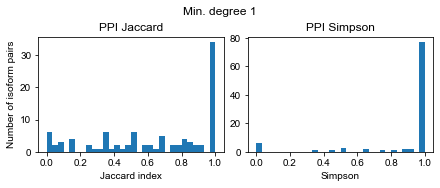

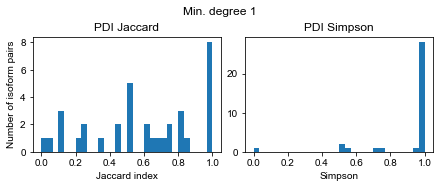

In [44]:
#  Jaccard/Simpson for PPI/PDI, histograms
def make_jaccard_simpson_hist(int_type, iso_pairs=iso_pairs, main_title='', nb=30):
    # int_type - ppi or pdi
    # nb - number of bins
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.5))
    fig.suptitle(main_title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.87]) # adjust to allow for subtitle

    ax1.hist(iso_pairs[int_type + '_jaccard'], bins=nb)
    ax1.set_title(int_type.upper() + ' Jaccard')
    ax1.set_xlabel('Jaccard index')
    ax1.set_ylabel('Number of isoform pairs')
    
    ax2.hist(iso_pairs[int_type + '_simpson'], bins=nb)
    ax2.set_title(int_type.upper() + ' Simpson')
    ax2.set_xlabel('Simpson')

# BUG - missing simpsons index   
make_jaccard_simpson_hist('PPI', iso_pairs, 'All')
make_jaccard_simpson_hist('PDI', iso_pairs, 'All')
make_jaccard_simpson_hist('PPI', iso_pairs.loc[iso_pairs['n_min_PPI']>=1, :], main_title='Min. degree 1')
make_jaccard_simpson_hist('PDI', iso_pairs.loc[iso_pairs['n_min_PDI']>=1, :], main_title='Min. degree 1')


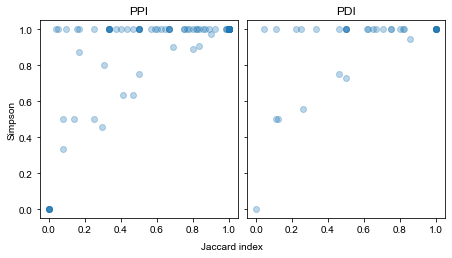

In [46]:
# Jaccard vs Simpson for PPI and PDI
def make_jaccard_simpson_plot(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

    alpha=0.3
    ax1.scatter(df['PPI_jaccard'], df['PPI_simpson'], alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_aspect('equal')
    ax2.scatter(df['PDI_jaccard'], df['PDI_simpson'], alpha=alpha)
    ax2.set_title('PDI')
    ax2.set_aspect('equal')

    fig.tight_layout()
    fig.text(0.5, 0.05, 'Jaccard index', ha='center')
    fig.text(-0.02, 0.5, 'Simpson', va='center', rotation='vertical')

make_jaccard_simpson_plot(iso_pairs) # only plotted for cases  with 1+ interactions for both iso. of a pair

SignificanceResult(statistic=nan, pvalue=nan)

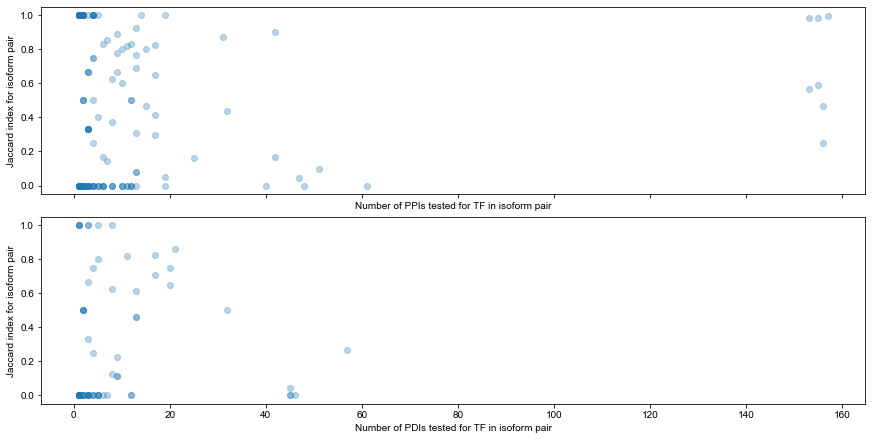

In [47]:
# Is there a relationship between degree and interaction profile similarity?
# For now use number of pdi/ppi tested as estimate of degree.
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(12,6))
alpha=0.3

ax1.scatter(iso_pairs.n_PPI_successfully_tested_in_ref_and_alt, iso_pairs.PPI_jaccard, alpha=alpha)
ax1.set_xlabel('Number of PPIs tested for TF in isoform pair')
ax1.set_ylabel('Jaccard index for isoform pair')

ax2.scatter(iso_pairs.n_PDI_successfully_tested_in_ref_and_alt, iso_pairs.PDI_jaccard, alpha=alpha)
ax2.set_xlabel('Number of PDIs tested for TF in isoform pair')
ax2.set_ylabel('Jaccard index for isoform pair')

fig.tight_layout()

# Luke question - how to determine if there is no bias between degree and Jaccard?
stats.spearmanr(iso_pairs.n_PPI_successfully_tested_in_ref_and_alt, iso_pairs.PPI_jaccard)
stats.spearmanr(iso_pairs.n_PDI_successfully_tested_in_ref_and_alt, iso_pairs.PDI_jaccard)

In [48]:
iso_pairs.sort_values(['PPI_jaccard', 'aa_seq_pct_id'], ascending=[True, False])

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,n_min_PPI,n_min_PDI,pdi_n_max,PPI_simpson,PDI_simpson
85,RBPJ,ENSG00000168214,CSL,False,RBPJ|2/4|07B11,RBPJ|1/4|01F06,ENST00000342320|ENST00000355476,ENST00000348160,False,False,True,486,487,11,11,True,False,False,False,False,False,False,False,0.0,0.0,False,99.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,NaN,loses some,loses some,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,True,3.279541,3.736935,0.457394,True,True,True,RBPJ-2,RBPJ-1,1.0,NaN,NaN,0.0,NaN
6,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,True,602,607,16,16,True,False,False,False,False,False,False,False,0.0,0.0,False,98.4,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,False,0.436213,0.248480,-0.187733,False,False,True,GRHL3-3,GRHL3-2,0.0,NaN,NaN,NaN,NaN
11,NFIA,ENSG00000162599,SMAD,True,NFIA|2/5|02G09,NFIA|3/5|02E09,ENST00000403491,ENST00000407417,False,False,True,509,501,11,11,True,False,False,False,False,False,False,False,0.0,0.0,False,98.2,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4.185884,2.340298,-1.845586,False,False,False,NFIA-2,NFIA-3,0.0,NaN,NaN,NaN,NaN
12,NFIA,ENSG00000162599,SMAD,True,NFIA|2/5|02G09,NFIA|4/5|02F09,ENST00000403491,ENST00000371187,False,False,True,509,498,11,10,False,True,True,True,False,True,False,False,0.0,0.0,False,93.4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,True,4.185884,4.517720,0.331835,False,False,True,NFIA-2,NFIA-4,0.0,NaN,NaN,NaN,NaN
246,ARNTL2,ENSG00000029153,bHLH,True,ARNTL2|2/5|12C06,ARNTL2|4/5|09F12,ENST00000395901,NaN,False,True,False,599,557,15,14,False,False,True,True,False,True,False,False,0.0,0.0,False,93.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.363099,NaN,NaN,False,False,False,ARNTL2-2,ARNTL2-4,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,ZNF696,ENSG00000185730,C2H2 ZF,False,ZNF696|1/2|08F01,ZNF696|2/2|08B03,ENST00000330143,ENST00000521537,False,False,True,374,37,2,1,False,True,False,True,False,False,False,False,0.0,100.0,True,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,ZNF696-1,ZNF696-2,NaN,NaN,NaN,NaN,NaN
403,ZNF175,ENSG00000105497,C2H2 ZF,False,ZNF175|1/3|12H06,ZNF175|3/3|02H02,ENST00000262259,ENST00000545217,False,False,True,711,51,4,1,False,True,False,True,False,False,False,False,0.0,100.0,True,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-1.314999,NaN,NaN,False,False,False,ZNF175-1,ZNF175-3,NaN,NaN,NaN,NaN,NaN
41

SignificanceResult(statistic=0.5474044831732612, pvalue=1.7013098031018198e-13)


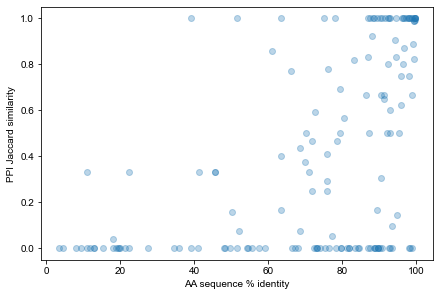

In [49]:
x = iso_pairs.loc[iso_pairs['PPI_jaccard'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['PPI_jaccard'].notnull(), 'PPI_jaccard'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('PPI Jaccard similarity')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../figures/PPI_jaccard_vs_aa_id.pdf',
            bbox_inches='tight')

SignificanceResult(statistic=0.4166656597873104, pvalue=0.00027189320984871083)


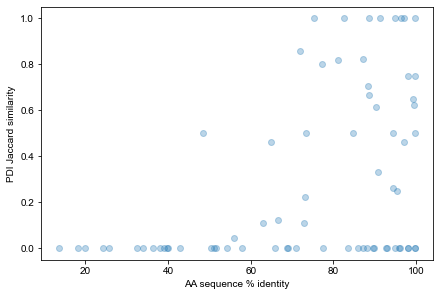

In [50]:
x = iso_pairs.loc[iso_pairs['PDI_jaccard'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['PDI_jaccard'].notnull(), 'PDI_jaccard'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('PDI Jaccard similarity')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../figures/PDI_jaccard_vs_aa_id.pdf',
            bbox_inches='tight')

SignificanceResult(statistic=0.1266450382751546, pvalue=0.02198651562741389)


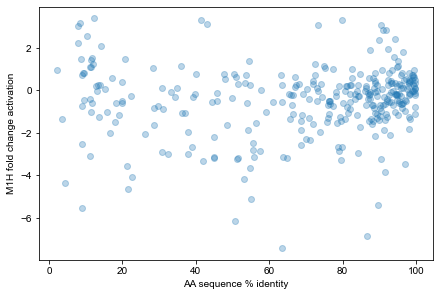

In [51]:
x = iso_pairs.loc[iso_pairs['activation_fold_change_log2'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['activation_fold_change_log2'].notnull(), 'activation_fold_change_log2'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('M1H fold change activation')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../figures/m1h_fold_change_vs_aa_id.pdf',
            bbox_inches='tight')

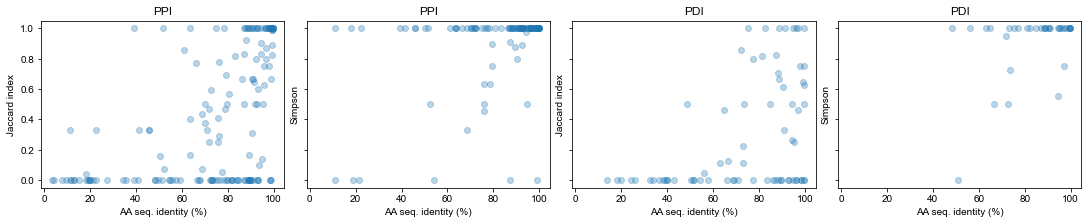

In [53]:
# Jaccard/Simpson versus similarity for PPI and PDI
def make_profile_diff_vs_seq_plot(df):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,3))
    fig.tight_layout()
    (ax1, ax2, ax3, ax4) = axs
    
    for ax in axs: ax.set_xlabel('AA seq. identity (%)')
        
    alpha=0.3
    
    ax1.scatter(df['aa_seq_pct_id'], df['PPI_jaccard'], alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_ylabel('Jaccard index')
    ax2.scatter(df['aa_seq_pct_id'], df['PPI_simpson'], alpha=alpha)
    ax2.set_title('PPI')
    ax2.set_ylabel('Simpson')
    ax3.scatter(df['aa_seq_pct_id'], df['PDI_jaccard'], alpha=alpha)
    ax3.set_title('PDI')
    ax3.set_ylabel('Jaccard index')
    ax4.scatter(df['aa_seq_pct_id'], df['PDI_simpson'], alpha=alpha)
    ax4.set_title('PDI')
    ax4.set_ylabel('Simpson')

make_profile_diff_vs_seq_plot(iso_pairs)

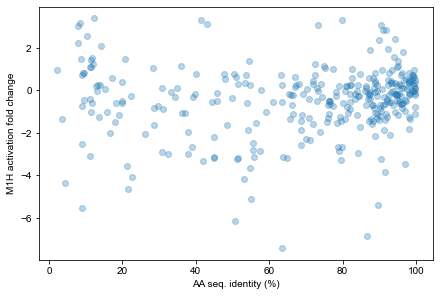

In [56]:
# Jaccard/Simpson versus similarity for M1H
fig, ax1 = plt.subplots(1, sharex=True, sharey=True)
fig.tight_layout()
alpha=0.3
ax1.scatter(iso_pairs['aa_seq_pct_id'],
            iso_pairs['activation_fold_change_log2'],
            alpha=alpha)
ax1.set_xlabel('AA seq. identity (%)')
ax1.set_ylabel('M1H activation fold change')
plt.savefig('../figures/M1H_fold_change_vs_aa_id.pdf',
            bbox_inches='tight')

In [57]:
# get isoform-specific y1h and y2h degree
deg = y1h.loc[:, y1h.columns[2:]].sum(axis=1).rename('y1h_degree')
y1h_nd = y1h[['tf', 'unique_acc']].join(deg, how='left')
y2h_nd = y2h.loc[y2h.category=='tf_isoform_ppis', :].groupby('ad_clone_acc')['ad_clone_acc'].count().rename('y2h_degree')
int_nd = y1h_nd.join(y2h_nd, how='outer', on='unique_acc')
int_nd.head()

,tf,unique_acc,y1h_degree,y2h_degree
0.0,CREB1,CREB1|1/2|02E01,0.0,NaN
1.0,CREB1,CREB1|2/2|01F12,4.0,NaN
2.0,DLX1,DLX1|1/2|07A12,3.0,NaN
3.0,DLX1,DLX1|2/2|07E09,0.0,NaN
4.0,DLX4,DLX4|1/3|11A04,1.0,NaN


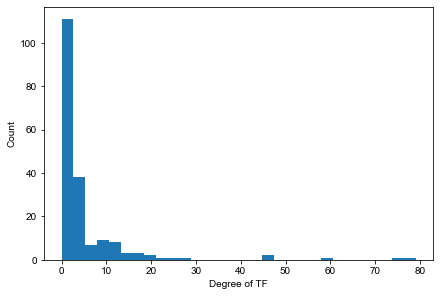

Text(0, 0.5, 'Count')

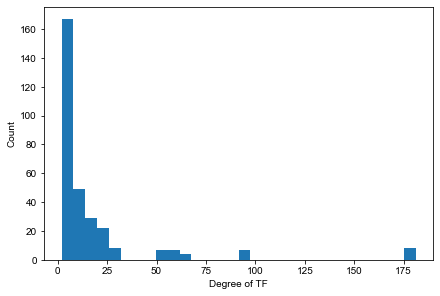

In [58]:
# plot the degree distributions
# degere of y1h
plt.hist(int_nd.y1h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')
plt.show()
plt.hist(int_nd.y2h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')

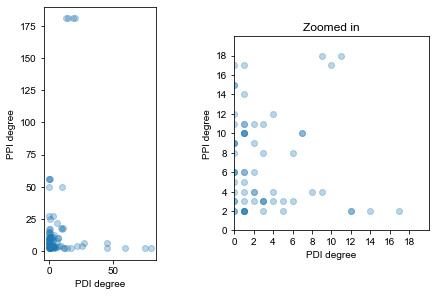

In [59]:
# compare pdi versus ppi degree
fig, (ax1, ax2) = plt.subplots(1,2)
alpha = 0.3

ax1.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax1.set_aspect('equal')
ax1.set_xlabel('PDI degree')
ax1.set_ylabel('PPI degree')

ax2.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax2.set_aspect('equal')
ax2.set_xlabel('PDI degree')
ax2.set_ylabel('PPI degree')
ax2.set_title('Zoomed in')
ax2.set_xlim(0,20)
ax2.set_xticks(range(0,20,2))
ax2.set_ylim(0,20)
ax2.set_yticks(range(0,20,2));
# ax2.set_yscale('log')
# ax2.set_xscale('log')


SignificanceResult(statistic=0.072607965172057, pvalue=0.41723282148193075)


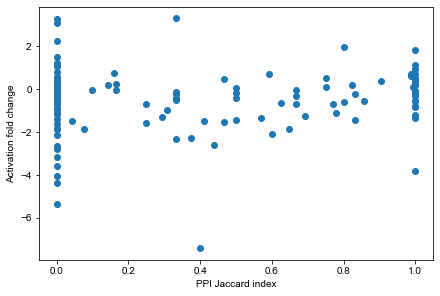

In [60]:
x = 'PPI_jaccard'
y = 'activation_fold_change_log2'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
plt.scatter(xy[x], xy[y])
plt.xlabel('PPI Jaccard index')
plt.ylabel('Activation fold change')
print(stats.spearmanr(xy[x], xy[y]))
plt.savefig('../figures/ppi_vs_activation.pdf',
            bbox_inches='tight')

(58, 62)
SignificanceResult(statistic=0.25823478848121906, pvalue=0.0503260974863003)


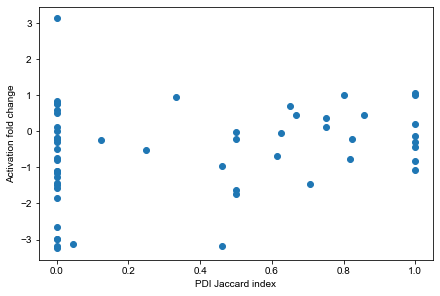

In [61]:
x = 'PDI_jaccard'
y = 'activation_fold_change_log2'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y])
plt.xlabel('PDI Jaccard index')
plt.ylabel('Activation fold change')
print(stats.spearmanr(xy[x], xy[y]))
plt.savefig('../figures/pdi_vs_activation.pdf',
            bbox_inches='tight')

(28, 62)


SignificanceResult(statistic=0.3521849906841739, pvalue=0.06606014719331338)

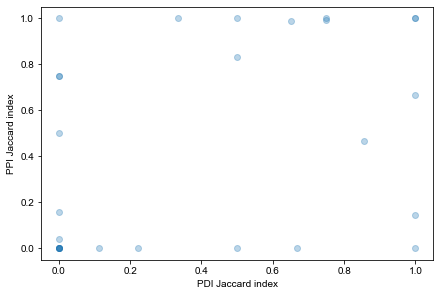

In [62]:
x = 'PDI_jaccard'
y = 'PPI_jaccard'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [63]:
x = 'PDI_jaccard'
y = 'PPI_jaccard'
print(iso_pairs['n_min_PPI']>=1)
print(iso_pairs[x].notnull())

0       True
1      False
2      False
3      False
4      False
       ...  
442    False
443    False
444    False
445     True
446    False
Name: n_min_PPI, Length: 447, dtype: bool
0       True
1      False
2       True
3      False
4      False
       ...  
442    False
443    False
444    False
445    False
446    False
Name: PDI_jaccard, Length: 447, dtype: bool


(11, 62)


SignificanceResult(statistic=-0.28436839595036684, pvalue=0.39671267837303836)

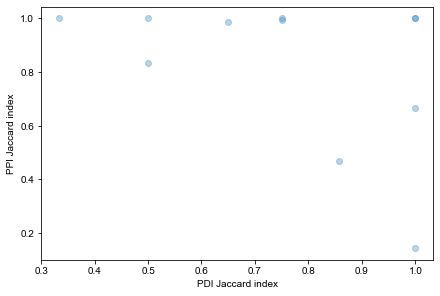

In [64]:
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull() & (iso_pairs['n_min_PPI']>=1) & (iso_pairs['n_min_PDI']>=1), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [65]:
# Look at direction of activation change? I.e. is the isoform with less binding partners
# the one with activation closer to 0?

In [67]:
# Check if this result is robust against requiring at least
# one interaction partner for both genes.
# To see if the effect is driven by non-functional isoforms.
x = 'PPI_jaccard'
y = 'activation_fold_change_log2'
xy = iso_pairs.loc[iso_pairs[x].notnull() &
                   iso_pairs[y].notnull() &
                   (iso_pairs['n_min_PPI'] >= 1), :]
print(xy.shape)
stats.spearmanr(xy[x], xy[y])

(81, 62)


SignificanceResult(statistic=0.2542052107781182, pvalue=0.022018707746573427)

In [68]:
xy.sort_values('activation_fold_change_log2', ascending=False).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,n_min_PPI,n_min_PDI,pdi_n_max,PPI_simpson,PDI_simpson
50,ATF2,ENSG00000115966,bZIP,True,ATF2|1/6|12H04,ATF2|5/6|09A05,ENST00000264110|ENST00000392544,ENST00000409833,False,False,True,505,209,12,6,False,True,False,True,False,False,False,False,0.0,100.000000,True,41.4,3.0,1.0,3.0,3.0,1.0,1.0,2.0,-2.0,0.333333,loses all,retains all,loses all,NaN,retains all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.361183,3.668095,3.306912,True,True,True,ATF2-1,ATF2-5,1.0,NaN,NaN,1.000000,NaN
35,ESRRG,ENSG00000196482,Nuclear receptor,True,ESRRG|1/2|09B10,ESRRG|2/2|09C10,NaN,NaN,True,True,False,463,442,7,6,True,False,False,False,True,False,False,False,0.0,0.000000,False,92.3,9.0,9.0,10.0,9.0,9.0,8.0,2.0,0.0,0.800000,retains all,loses some,loses some,gains some,retains all,3.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.379506,3.335048,1.955542,True,True,True,ESRRG-1,ESRRG-2,9.0,NaN,NaN,0.888889,NaN
47,ATF2,ENSG00000115966,bZIP,True,ATF2|1/6|12H04,ATF2|2/6|09E05,ENST00000264110|ENST00000392544,ENST00000426833,False,False,True,505,487,12,11,True,False,False,False,True,False,False,False,0.0,0.000000,False,96.4,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,1.000000,retains all,retains all,retains all,NaN,retains all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.361183,2.170020,1.808837,True,True,True,ATF2-1,ATF2-2,3.0,NaN,NaN,1.000000,NaN
74,RARB,ENSG00000077092,Nuclear receptor,True,RARB|1/2|12H03,RARB|2/2|08B05,ENST00000330688,ENST00000437042|ENST00000458646,False,False,True,448,336,8,6,True,False,False,False,True,False,False,False,0.0,48.571429,True,75.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.000000,retains all,NaN,retains all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.593940,4.731984,1.138044,True,True,True,RARB-1,RARB-2,1.0,NaN,NaN,1.000000,NaN
125,ZNF451,ENSG00000112200,C2H2 ZF,False,ZNF451|2/8|06C02,ZNF451|7/8|06D01,ENST00000370708,NaN,False,True,False,559,65,4,4,False,True,False,False,False,False,False,False,NaN,NaN,False,11.1,1.0,2.0,3.0,1.0,2.0,0.0,3.0,1.0,0.000000,NaN,gains some,gains some,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.072313,2.146779,1.074466,True,True,True,ZNF451-2,ZNF451-7,1.0,NaN,NaN,0.000000,NaN


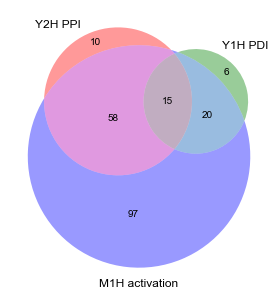

In [69]:
# overlaps

a = set(iso_pairs.loc[iso_pairs['PPI_jaccard'].notnull(), 'gene_symbol'].unique())
b = set(iso_pairs.loc[iso_pairs['PDI_jaccard'].notnull(), 'gene_symbol'].unique())
c = set(iso_pairs.loc[iso_pairs['activation_fold_change_log2'].notnull(), 'gene_symbol'].unique())
from matplotlib_venn import venn3

venn3([a, b, c],
      set_labels=['Y2H PPI', 'Y1H PDI', 'M1H activation'])
plt.savefig('../figures/tf_gene_data_integration_venn.pdf')

In [70]:
ppi['Y2H_result'].value_counts()

True     2173
False    1568
Name: Y2H_result, dtype: int64

In [71]:
ppi['Y2H_result'].notnull().sum() / ppi.shape[0]

0.9795758051846033

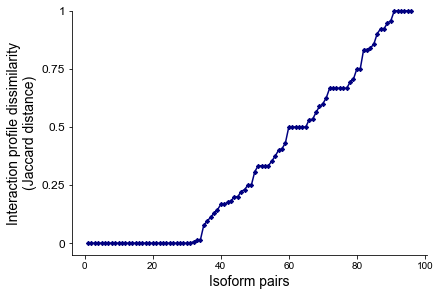

In [72]:
def remake_yang_et_al_fig_2b(values, color='navy'):
    ax.plot(range(1, values.shape[0] + 1),
            sorted(values),
            marker='D',
            markersize=3,
            color=color,
            clip_on=False)
    ax.set_xlabel('Isoform pairs', fontsize=14)
    ax.set_ylabel('Interaction profile dissimilarity\n(Jaccard distance)',
                  fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{:g}'.format(t) for t in ax.get_yticks()],
                       fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], 1)
    

fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['PPI_jaccard'].notnull() &
                       (iso_pairs['n_min_PPI'] >= 1),
                       'PPI_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../figures/remake_yang_et_al_fig4B.pdf',
            bbox_inches='tight')

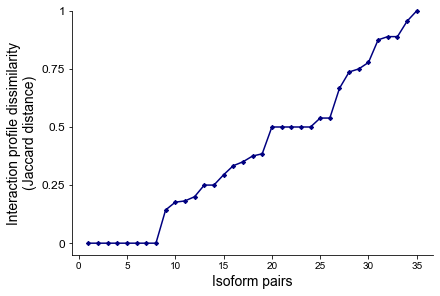

In [73]:
fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['PDI_jaccard'].notnull() &
                       (iso_pairs['n_min_PDI'] >= 1),
                       'PDI_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../figures/remake_yang_et_al_fig4B_PDI.pdf',
            bbox_inches='tight')

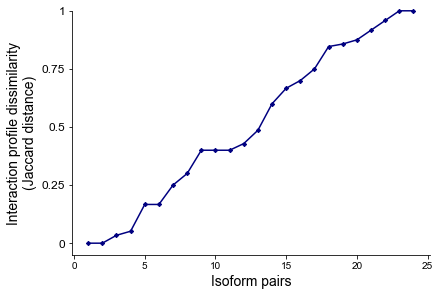

In [74]:
# combine PPI and PDI
iso_pairs['ppi_PDI_jaccard'] = ((iso_pairs['n_shared_PPI'] + iso_pairs['n_shared_PDI']) / 
                                (iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] + iso_pairs['n_PDI_successfully_tested_in_ref_and_alt']))
fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) | (iso_pairs['n_min_PDI'] >= 1)),
                       'ppi_PDI_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../figures/remake_yang_et_al_fig4B_combine_PDI_PPI.pdf',
            bbox_inches='tight')

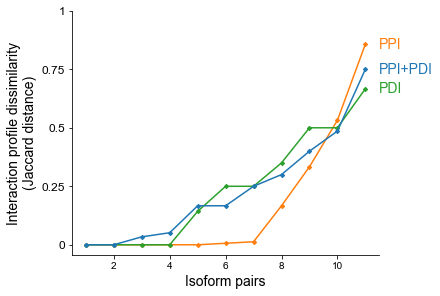

In [75]:
# all on one plot
fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) & (iso_pairs['n_min_PDI'] >= 1)),
                       'PPI_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) & (iso_pairs['n_min_PDI'] >= 1)),
                       'PDI_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) & (iso_pairs['n_min_PDI'] >= 1)),
                       'ppi_PDI_jaccard'].values
remake_yang_et_al_fig_2b(values_ppi, color='C1')
remake_yang_et_al_fig_2b(values_pdi, color='C2')
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        values_pdi.max(), 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_all_one_plot.pdf',
            bbox_inches='tight')

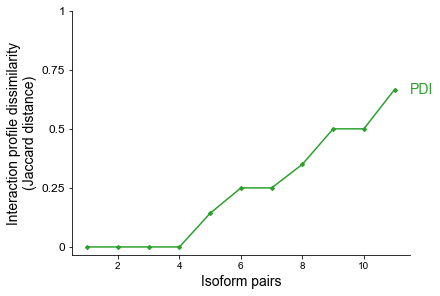

In [76]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_pdi, color='C2')
ax.text(ax.get_xlim()[1], 
        values_pdi.max(), 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
plt.savefig('../figures/remake_yang_et_al_fig4B_PDI.pdf',
            bbox_inches='tight')

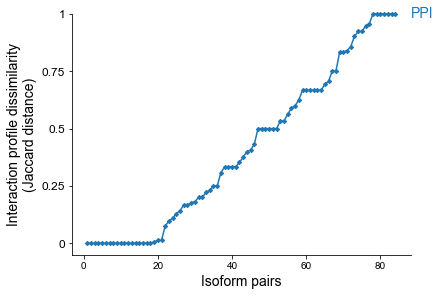

In [77]:
# TEMP: make with (2020-07-30)
ys = 1 - iso_pairs.loc[(iso_pairs['n_PPI_successfully_tested_in_ref_and_alt'] >= 2)
               & iso_pairs['both_iso_y2h_pos'],
               'PPI_jaccard'].values


fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(ys, color='C0')
ax.text(ax.get_xlim()[1], 
        ys.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C0')
plt.savefig('../figures/PPI_jaccard_20200730.pdf',
            bbox_inches='tight')

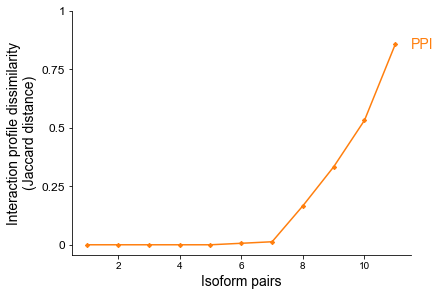

In [78]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_ppi, color='C1')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
plt.savefig('../figures/remake_yang_et_al_fig4B_PPI.pdf',
            bbox_inches='tight')

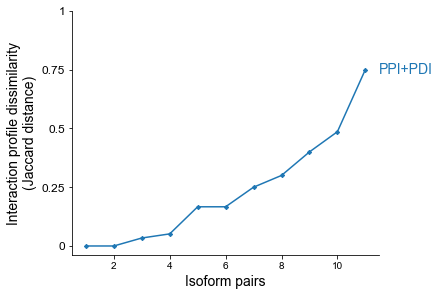

In [79]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_both.pdf',
            bbox_inches='tight')

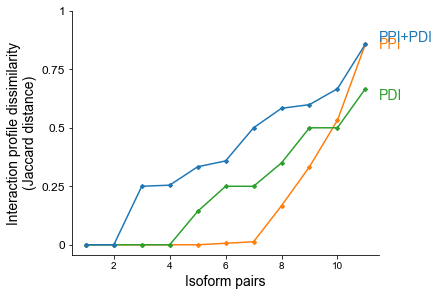

In [80]:
# product
fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) & (iso_pairs['n_min_PDI'] >= 1)),
                       'PPI_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) & (iso_pairs['n_min_PDI'] >= 1)),
                       'PDI_jaccard'].values
values_ppi_pdi = 1 - (iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) & (iso_pairs['n_min_PDI'] >= 1)),
                       'PPI_jaccard'].values
                     * iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) & (iso_pairs['n_min_PDI'] >= 1)),
                       'PDI_jaccard'].values)
remake_yang_et_al_fig_2b(values_ppi, color='C1')
remake_yang_et_al_fig_2b(values_pdi, color='C2')
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        values_pdi.max() - 0.03, 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max() + 0.03, 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_all_one_plot_product.pdf',
            bbox_inches='tight')

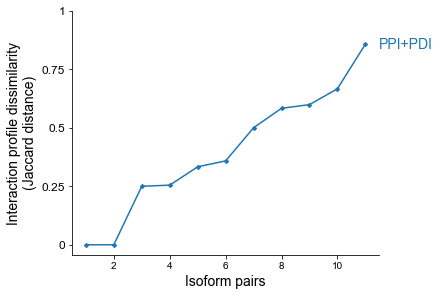

In [81]:
fig, ax = plt.subplots(1, 1)
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_pdi_ppi_product.pdf',
            bbox_inches='tight')

In [82]:
values_ppi

array([0.16666667, 0.85714286, 0.33333333, 0.        , 0.        ,
       0.00636943, 0.01290323, 0.53205128, 0.        , 0.        ,
       0.        ])

In [83]:
values_ppi_pdi

array([0.58333333, 0.85714286, 0.33333333, 0.        , 0.        ,
       0.25477707, 0.3583871 , 0.5989011 , 0.25      , 0.66666667,
       0.5       ])

(array([4., 1., 0., 2., 0., 1., 1., 1., 0., 1.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667]),
 <BarContainer object of 10 artists>)

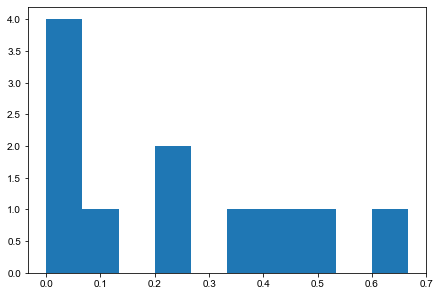

In [84]:
plt.hist(values_ppi_pdi - values_ppi)

In [85]:
stats.ttest_rel(values_ppi, values_ppi_pdi)

TtestResult(statistic=-3.2047613815663065, pvalue=0.009415333512322684, df=10)

In [86]:
stats.wilcoxon(values_ppi, values_ppi_pdi)

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.017960477526078766)

In [87]:
stats.ks_2samp(values_ppi, values_ppi_pdi)

KstestResult(statistic=0.5454545454545454, pvalue=0.0746606334841629, statistic_location=0.16666666666666663, statistic_sign=1)

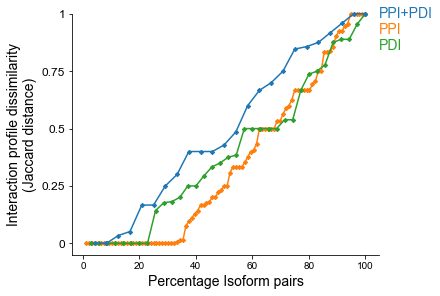

In [88]:
def remake_yang_et_al_fig_2b_pct_x(values, color='navy'):
    ax.plot(np.linspace(0, 100, values.shape[0] + 1)[1:],
            sorted(values),
            marker='D',
            markersize=3,
            color=color,
            clip_on=False)
    ax.set_xlabel('Percentage Isoform pairs', fontsize=14)
    ax.set_ylabel('Interaction profile dissimilarity\n(Jaccard distance)',
                  fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{:g}'.format(t) for t in ax.get_yticks()],
                       fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], 1)


fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['PPI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1)),
                       'PPI_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PDI'] >= 1)),
                       'PDI_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_PDI_jaccard'].notnull() &
                       ((iso_pairs['n_min_PPI'] >= 1) | (iso_pairs['n_min_PDI'] >= 1)),
                       'ppi_PDI_jaccard'].values
remake_yang_et_al_fig_2b_pct_x(values_ppi, color='C1')
remake_yang_et_al_fig_2b_pct_x(values_pdi, color='C2')
remake_yang_et_al_fig_2b_pct_x(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        0.93, 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        0.86, 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        1, 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../figures/remake_yang_et_al_fig4B_all_one_plot_pct_isoforms.pdf',
            bbox_inches='tight')

In [89]:
stats.ks_2samp(values_ppi, values_ppi_pdi)

KstestResult(statistic=0.2708333333333333, pvalue=0.10682600965321219, statistic_location=0.013071895424836555, statistic_sign=1)

In [90]:
stats.ks_2samp(values_pdi, values_ppi_pdi)

KstestResult(statistic=0.20952380952380953, pvalue=0.47777391486519527, statistic_location=0.3846153846153846, statistic_sign=1)

In [91]:
iso_pairs.loc[(iso_pairs['PDI_jaccard'] == 0) &
              (iso_pairs['n_min_PDI'] >= 1), :]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,both_iso_y2h_pos,both_iso_y2h_pos_all_data,both_iso_y2h_or_y1h_pos,isoform_a,isoform_b,n_min_PPI,n_min_PDI,pdi_n_max,PPI_simpson,PDI_simpson,ppi_PDI_jaccard
276,MAX,ENSG00000125952,bHLH,True,MAX|1/6|08G02,MAX|4/6|08A03,ENST00000358664,ENST00000556443,False,False,True,160,125,5,3,False,True,True,True,False,True,False,False,0.0,0.0,False,51.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1.0,46.0,45.0,1.0,0.0,0.0,True,1.755586,-1.486114,-3.2417,False,False,True,MAX-1,MAX-4,NaN,1.0,45.0,NaN,0.0,NaN
